### 필요 라이브러리 로드

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize']=14
matplotlib.rcParams['xtick.labelsize']=12
matplotlib.rcParams['ytick.labelsize']=12
matplotlib.rcParams['text.color']='k'

In [2]:
pd.set_option('display.max_columns',500) 
#출력시 생략 X

### 데이터셋 설정 

In [3]:
#df=pd.read_csv("BG_sample2.csv")
#df=pd.read_excel("BG_sample18.xlsx")
df=pd.read_excel("BG_sample18.xlsx")

In [4]:
df.shape

(1474, 14)

In [5]:
df.head(13)

,색인,타임스탬프(YYYY-MM-DDThh:mm:ss),이벤트 유형,이벤트 하위 유형,환자 정보,장치 정보,소스 장치 ID,포도당 값 (mg/dL),인슐린 값(u),탄수화물 값 (그램),기간(hh:mm:ss),포도당 변화율 (mg/dL/min),트랜스미터 시간 (배장 정수),트랜스미터 ID
0,1,NaN,이름,NaN,sch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,성,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,생년월일,NaN,1983-01-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,장치,NaN,NaN,Dexcom G5 Mobile App,Android,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,경고,하락,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
5,6,NaN,경고,높음,NaN,NaN,Android,250,NaN,NaN,NaN,NaN,NaN,NaN
6,7,NaN,경고,낮음,NaN,NaN,Android,70,NaN,NaN,NaN,NaN,NaN,NaN
7,8,NaN,경고,신호 손실,NaN,NaN,Android,NaN,NaN,NaN,00:30:00,NaN,NaN,NaN
8,9,NaN,경고,상승,NaN,NaN,Android,NaN,NaN,NaN,NaN,3.0,NaN,NaN
9,10,NaN,경고,긴급하게 낮음,NaN,NaN,Android,55,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#필요없는 열 제거
cols = ['색인', '이벤트 하위 유형', '환자 정보', '장치 정보', '소스 장치 ID', '인슐린 값(u)', '탄수화물 값 (그램)', '기간(hh:mm:ss)', '포도당 변화율 (mg/dL/min)', '트랜스미터 시간 (배장 정수)', '트랜스미터 ID']
df.drop(cols, axis=1, inplace=True)


In [7]:
df=df.rename({'타임스탬프(YYYY-MM-DDThh:mm:ss)':'Timestamp','포도당 값 (mg/dL)':'Glucose','이벤트 유형':'Event'},axis='columns')

In [8]:
df['Event'].value_counts()

EGV     1422
인슐린       21
탄수화물      17
경고         6
교정         4
성          1
장치         1
이름         1
생년월일       1
Name: Event, dtype: int64

In [9]:
df['Glucose'].value_counts()

높음     169
199     27
187     20
185     19
197     18
      ... 
366      1
367      1
380      1
171      1
55       1
Name: Glucose, Length: 242, dtype: int64

In [10]:
df.tail()

,Timestamp,Event,Glucose
1469,2020-03-18T09:20:43,EGV,높음
1470,2020-03-18T09:25:44,EGV,높음
1471,2020-03-18T09:30:43,EGV,높음
1472,2020-03-18T09:35:44,EGV,높음
1473,2020-03-18T09:40:44,EGV,높음


In [11]:
df.head(15)

,Timestamp,Event,Glucose
0,NaN,이름,NaN
1,NaN,성,NaN
2,NaN,생년월일,NaN
3,NaN,장치,NaN
4,NaN,경고,NaN
5,NaN,경고,250
6,NaN,경고,70
7,NaN,경고,NaN
8,NaN,경고,NaN
9,NaN,경고,55


In [12]:
# Timestamp != NaN일 때까지 count하고 
# Nan에 해당하는 인스턴스 제거 
df=df.dropna(subset=['Timestamp'])

In [13]:
df.head(15)

,Timestamp,Event,Glucose
10,2020-03-13T11:05:03,교정,216
11,2020-03-13T11:14:06,교정,244
12,2020-03-13T11:15:55,EGV,227
13,2020-03-13T11:20:50,EGV,227
14,2020-03-13T11:25:49,EGV,224
15,2020-03-13T11:30:49,EGV,223
16,2020-03-13T11:35:49,EGV,222
17,2020-03-13T11:40:50,EGV,222
18,2020-03-13T11:45:51,EGV,218
19,2020-03-13T11:50:49,EGV,218


In [14]:
df.shape

(1464, 3)

In [15]:
# drop한 인스턴스가 있어서 인덱스 리셋
df=df.sort_values(by=['Timestamp'],axis=0,ascending=True)
df=df.reset_index(drop=True)

In [16]:
df.head(15)

,Timestamp,Event,Glucose
0,2020-03-13T11:05:03,교정,216
1,2020-03-13T11:14:06,교정,244
2,2020-03-13T11:15:55,EGV,227
3,2020-03-13T11:20:50,EGV,227
4,2020-03-13T11:25:49,EGV,224
5,2020-03-13T11:30:49,EGV,223
6,2020-03-13T11:35:49,EGV,222
7,2020-03-13T11:40:50,EGV,222
8,2020-03-13T11:45:51,EGV,218
9,2020-03-13T11:50:49,EGV,218


In [17]:
df.shape

(1464, 3)

In [18]:
# 높음, 낮음, 교정 인덱스 저장 
high_list=[]
low_list=[]
calib_list=[]

In [19]:
# 혈당 '높음' 빈도 카운트
def glucose_count_high(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='높음':
            count=count+1
            high_list.append(i)
    print('높음 : ',count)
    

In [20]:
# 혈당 '낮음' 빈도 카운트
def glucose_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='낮음':
            count=count+1
            low_list.append(i)
    print('낮음 : ',count)

In [21]:
# 혈당 '교정' 빈도 카운트
def calibration_count_low(df,col):
    count=0
    for i, row in df.iterrows():
         val = row[col]
         if val=='교정':
            count=count+1
            calib_list.append(i)
    print('교정 : ',count)

In [22]:
glucose_count_high(df,'Glucose')

높음 :  169


In [143]:
print('높음 개수 :',len(high_list))

높음 개수 : 169


In [145]:
print('낮음 개수 :',len(low_list))

낮음 개수 : 0


In [144]:
print('교정 개수 :',len(calib_list))

교정 개수 : 4


In [24]:
glucose_count_low(df,'Glucose')

낮음 :  0


In [25]:
low_list

[]

In [26]:
calibration_count_low(df,'Event')

교정 :  4


In [27]:
calib_list

[0, 1, 139, 414]

In [28]:
df.isnull().sum()

Timestamp     0
Event         0
Glucose      38
dtype: int64

In [29]:
df['Event'].value_counts()

EGV     1422
인슐린       21
탄수화물      17
교정         4
Name: Event, dtype: int64

### 높음 낮음 고정 (추후 전처리 과정에서 400,408,416,408,400 이런 식으로 선형으로 변환해줄 것)

In [30]:
def fix_glucose(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='높음':
            df.loc[i,col] = 400

In [31]:
def fix_glucose_low(df,col):
    for i, row in df.iterrows():
        val = row[col]
        if val=='낮음':
            df.loc[i,col] = 60

In [32]:
fix_glucose(df,'Glucose')

In [33]:
fix_glucose_low(df,'Glucose')

In [34]:
df['Glucose'].value_counts()

400    169
199     27
187     20
185     19
197     18
      ... 
171      1
169      1
389      1
366      1
145      1
Name: Glucose, Length: 240, dtype: int64

In [35]:
df.isnull().sum()

Timestamp     0
Event         0
Glucose      38
dtype: int64

In [36]:
df['Event'].unique()

array(['교정', 'EGV', '인슐린', '탄수화물'], dtype=object)

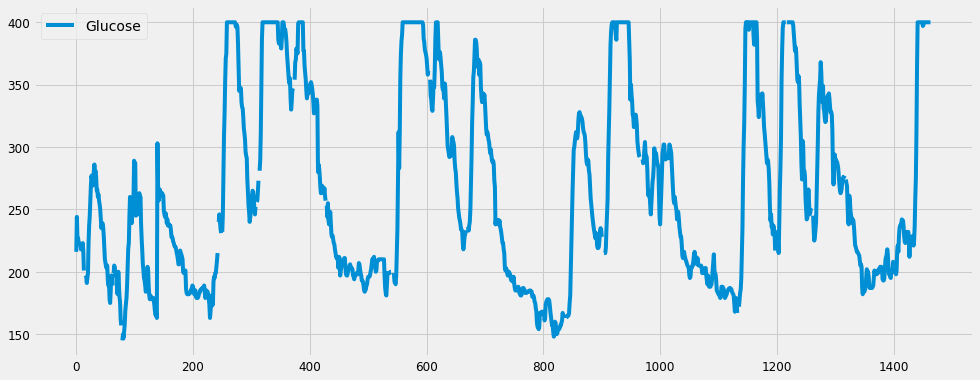

In [37]:
df.plot(figsize=(15,6))
plt.show()

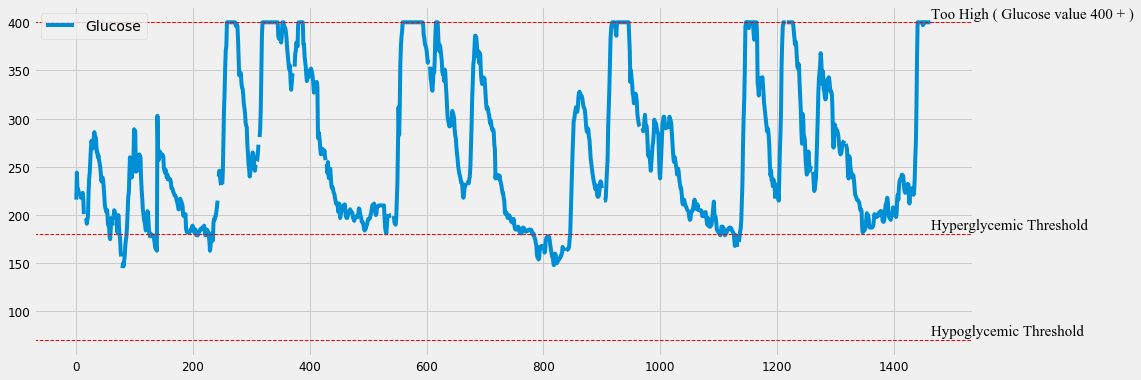

In [38]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [39]:
# 인슐린, 탄수화물 투여시 혈당값 NULL
# 그래서 t시점에 t-2 , t-1 크기비교해서 upper면 이렇게 lower면 이렇게 해서 interpolation ( 보간)
# 이거 위에 참고사항 drop하고 나서 적용 해줘야됨
insul=list()
import math
def interpolate_glucose(df,col):
    #insul=list()
    
    for i, row in df.iterrows():
        val=row[col]
        if math.isnan(val):
            if df['Glucose'][i-2] >= df['Glucose'][i-1]:
                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
                df.loc[i,col]= df['Glucose'][i-1] - c
                insul.append(i)
                print(insul)
                
            if df['Glucose'][i-2] < df['Glucose'][i-1]:
                c = (df['Glucose'][i-2] - df['Glucose'][i-1]) / 2 
                df.loc[i,col]= df['Glucose'][i-1] - c
                insul.append(i)
                print(insul)
        
           

In [40]:
interpolate_glucose(df,'Glucose')

[14]
[14, 15]
[14, 15, 63]
[14, 15, 63, 78]
[14, 15, 63, 78, 243]
[14, 15, 63, 78, 243, 249]
[14, 15, 63, 78, 243, 249, 308]
[14, 15, 63, 78, 243, 249, 308, 313]
[14, 15, 63, 78, 243, 249, 308, 313, 372]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604, 605]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604, 605, 669]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604, 605, 669, 670]
[14, 15, 63, 78, 243, 249, 308, 313, 372, 373, 428, 540, 541, 542, 543, 604, 605, 669, 670, 720]
[14,

In [41]:
glucose_value=list()
for i in range(0,len(insul)):
    glucose_value.append(df['Glucose'][insul[i]])

In [42]:
#len = len(df['Timestamp'])
#plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)

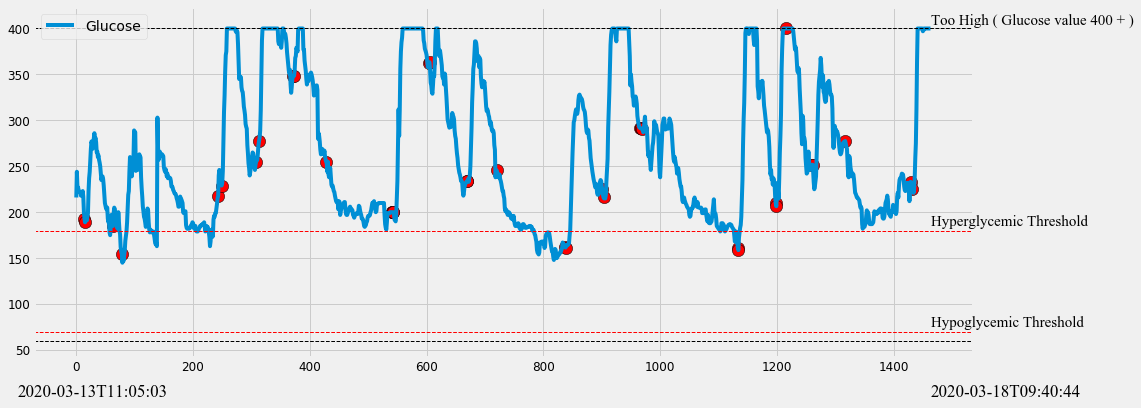

In [43]:

df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='black',linestyle='--',linewidth=1)
plt.axhline(y=60,c='black',linestyle='--',linewidth=1)
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.scatter(insul,glucose_value,c='red',edgecolor='black',s=150)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),60,'',family='Times New Roman',size=15)
#plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])],family='Times New Roman',
#         fontweight='bold',size=20)
plt.text(-100,-1,df['Timestamp'][0],family='Times New Roman',fontweight='bold',size=17)
plt.text(len(df['Timestamp']),-1,df['Timestamp'][len(df['Timestamp'])-1],family='Times New Roman',fontweight='bold',size=17)
#plt.text(-100,-1,df['Timestamp'][14],family='Times New Roman',
#         fontweight='bold',size=20)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

## 이제 여기부터 DL 모델 돌려볼 것 
+ 일단 모델부터 간단하게 돌려보고 성능 측정
+ 그리고 전처리 해가면서 성능 비교

## RNN

In [147]:
from keras.layers import SimpleRNN

In [435]:
model = Sequential()
model.add(SimpleRNN(50,activation='relu',input_shape=(n_steps,n_features),return_sequences=False))
model.add(Dense(1))

In [436]:
model.compile(optimizer='adam',loss='mse')

In [437]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [291]:
predict_result = model.predict(x_val_uni,verbose=0)

In [292]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [294]:
print(' Vanila RNN (Simple RNN) - RMSE (60min) : ',RMSE(y_val_uni,predict_result))

 Vanila RNN (Simple RNN) - RMSE (60min) :  49.97320777139457


In [438]:
# 트레이닝셋 rmse 구하는 부분 
predict_result = model.predict(x_train_uni,verbose=0)
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400            
print(' Training set / Vanila RNN (Simple RNN) - RMSE (15min) : ',RMSE(y_train_uni,predict_result))

 Training set / Vanila RNN (Simple RNN) - RMSE (15min) :  42.728474360572335


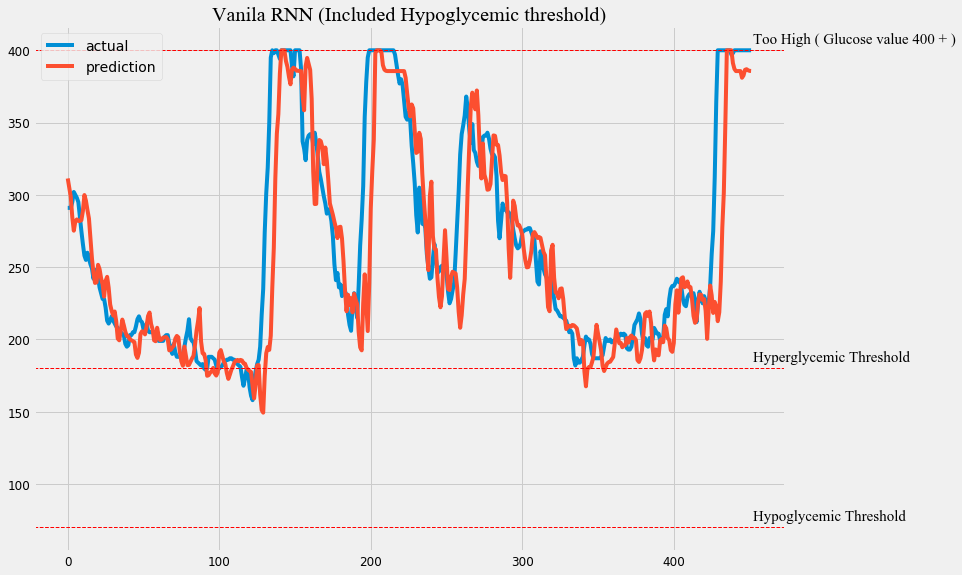

In [163]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Included Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

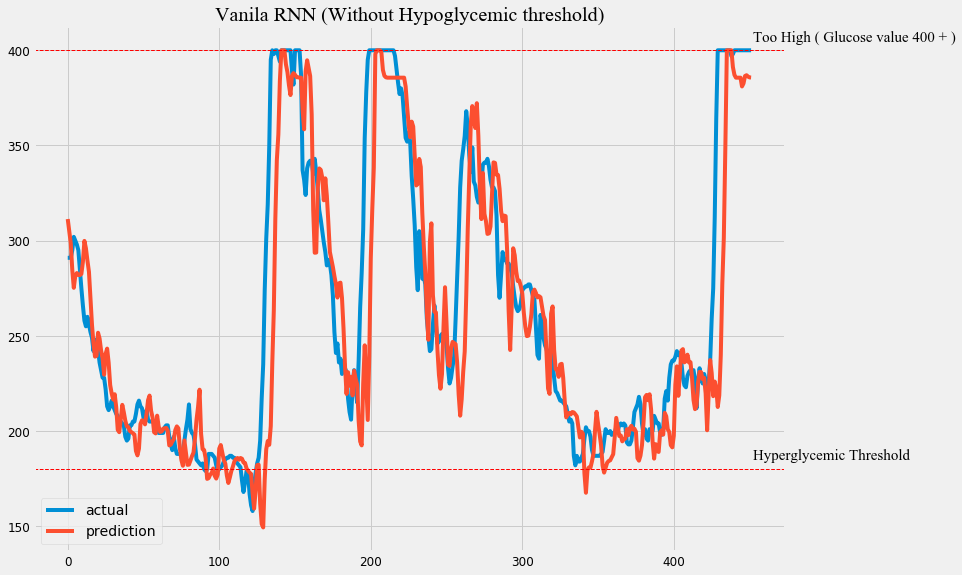

In [160]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
#plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('Vanila RNN (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [347]:
predict_result = model.predict(x_train_uni,verbose=0)
                               # 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

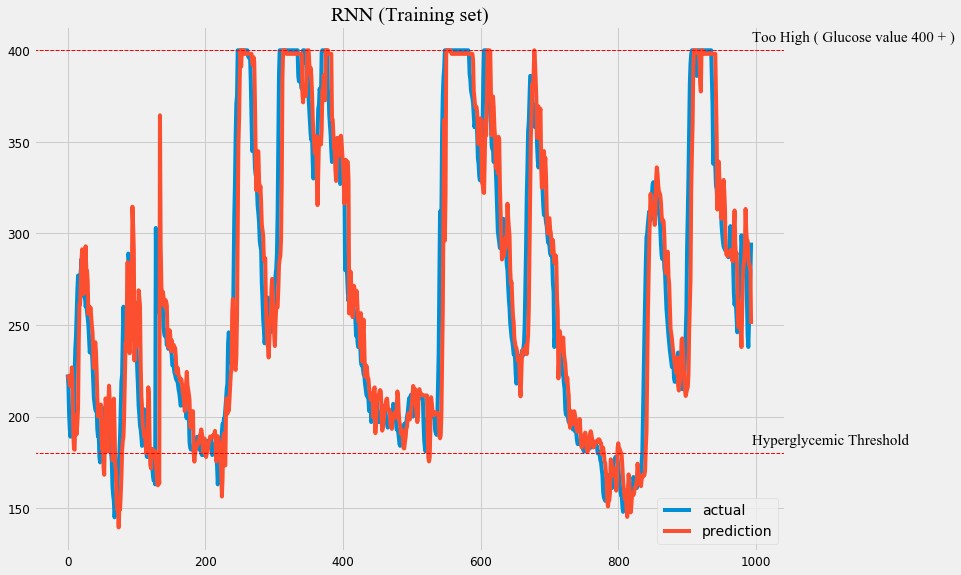

In [349]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
#plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('RNN (Training set)',family='Times New Roman')
plt.legend()
plt.show()

#### 잔차

In [206]:
from pandas import DataFrame
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
#residuals=DataFrame(residuals)

In [211]:
residuals = y_val_uni - predict_result.reshape(-1)

In [212]:
residuals

array([-2.03624573e+01, -1.40344849e+01, -7.62451172e+00,  1.04507141e+01,
        2.67601318e+01,  1.83554993e+01,  1.49898071e+01,  1.29749756e+01,
        3.08142090e+00, -7.55148315e+00, -2.28858643e+01, -4.18766174e+01,
       -4.09960327e+01, -2.95419006e+01, -2.76272583e+01, -1.72311096e+01,
       -6.81581116e+00, -3.94831848e+00,  8.89967346e+00,  8.53523254e+00,
       -8.64465332e+00, -1.26671295e+01, -1.04059143e+01, -1.00764008e+01,
       -1.62724304e+00, -1.85435028e+01, -3.03177643e+01, -2.48735199e+01,
       -1.12008514e+01, -3.70167542e+00, -3.54693604e+00, -8.35859680e+00,
       -3.51841736e+00,  7.36856079e+00,  6.58215332e+00, -1.29071045e+00,
       -9.76211548e+00, -6.88624573e+00, -8.42591858e+00, -7.45140076e+00,
       -6.11486816e+00,  2.94343567e+00,  3.53289795e+00,  6.14810181e+00,
        6.81147766e+00,  1.94204712e+01,  2.67649384e+01,  2.52398682e+01,
        9.24488831e+00,  6.35432434e+00,  1.66789246e+00,  2.49052429e+00,
        2.02687073e+00, -

Text(0.5, 1.0, 'Normal Q-Q Plot')

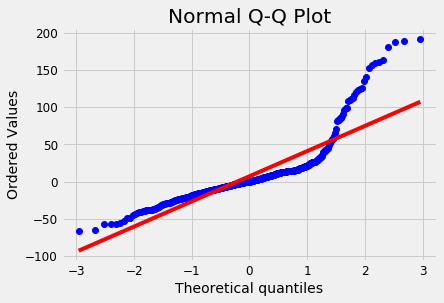

In [215]:
stats.probplot(residuals,dist="norm",plot=plt)
plt.title("Normal Q-Q Plot")

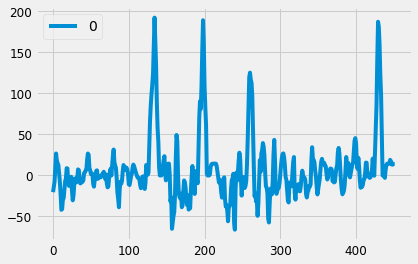

In [181]:
residuals.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000022161EBF550>]],
      dtype=object)

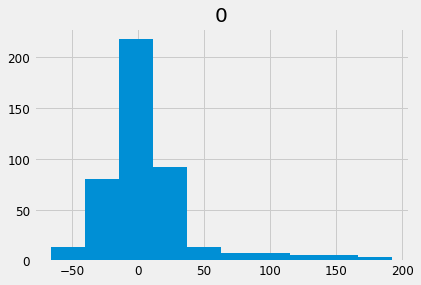

In [164]:

residuals.hist()

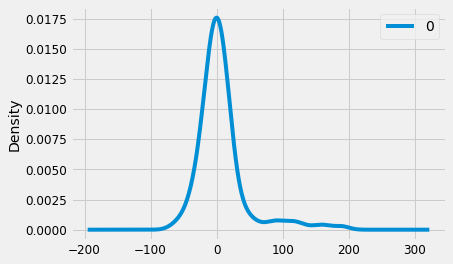

In [182]:
residuals.plot(kind='kde')

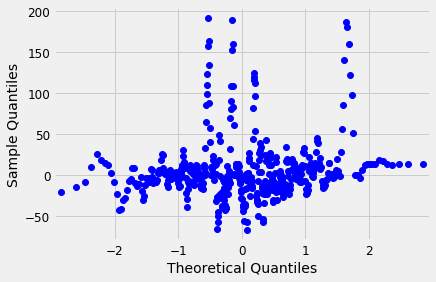

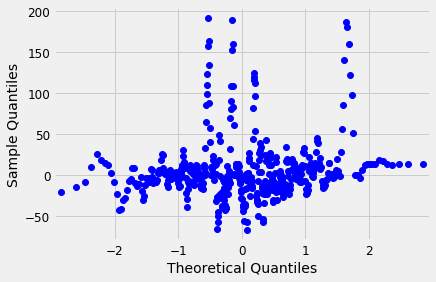

In [183]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

## LSTM

In [109]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i +n_steps 
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)
    

In [110]:
# 딜레이 추가 ( 15분 뒤, 30분 뒤)
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i +n_steps 
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)
    

In [258]:
def uni_data(dataset,start_index,end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
    #if end_index > len(dataset)-1:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        #data.append(np.reshape(dataset[indices],(history_size)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [259]:
raw_seq = df['Glucose']
raw_seq=raw_seq.to_numpy(dtype='int64')
n_steps = 3
delay=3

In [134]:
raw_seq_test = df['Glucose']
rw_seq_test=raw_seq_test.to_numpy(dtype='int64')
n_steps = 3
delay=3

In [135]:
X, y = split_sequence(raw_seq_test,n_steps)

In [434]:
TRAIN_SPLIT=1000
uni_past_history=6
uni_future_target=9
x_train_uni,y_train_uni = uni_data(raw_seq,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(raw_seq,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [59]:
X,y = uni_data(raw_seq,0,len(raw_seq),
                                  uni_past_history,
                                  uni_future_target)

IndexError: index 1464 is out of bounds for axis 0 with size 1464

In [117]:
X,y = split_sequence(raw_seq_test,n_steps)

In [234]:
x_train_uni.shape

(994, 6, 1)

In [239]:
y_train_uni.shape

(994,)

In [235]:
y_val_uni.shape

(453,)

In [236]:
x_train_uni

array([[[216],
        [244],
        [227],
        [227],
        [224],
        [223]],

       [[244],
        [227],
        [227],
        [224],
        [223],
        [222]],

       [[227],
        [227],
        [224],
        [223],
        [222],
        [222]],

       ...,

       [[294],
        [295],
        [295],
        [291],
        [287],
        [286]],

       [[295],
        [295],
        [291],
        [287],
        [286],
        [283]],

       [[295],
        [291],
        [287],
        [286],
        [283],
        [263]]], dtype=int64)

In [237]:
df['Glucose'].head(20)

0     216
1     244
2     227
3     227
4     224
5     223
6     222
7     222
8     218
9     218
10    218
11    223
12    217
13    201
14    193
15    189
16    197
17    196
18    191
19    195
Name: Glucose, dtype: object

In [249]:
y_train_uni[0]

223

In [250]:
x_train_uni[0]

array([[216],
       [244],
       [227],
       [227],
       [224],
       [223]], dtype=int64)

In [240]:
x_val_uni.shape

(453, 6, 1)

In [241]:
y_val_uni.shape

(453,)

In [231]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [64]:
n_features = 1
X = X.reshape((X.shape[0],X.shape[1],n_features))

NameError: name 'X' is not defined

In [395]:
model = Sequential()
model.add(LSTM(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))


In [396]:
model.compile(optimizer='adam',loss='mse')

In [397]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [353]:
predict_result = model.predict(x_val_uni,verbose=0)

In [354]:
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [329]:
predict_result

array([[330.49487],
       [322.71774],
       [297.7796 ],
       [275.59497],
       [272.5854 ],
       [273.6982 ],
       [272.80255],
       [272.02756],
       [272.2041 ],
       [272.15628],
       [276.5691 ],
       [288.53848],
       [282.7604 ],
       [278.73477],
       [275.35455],
       [270.52585],
       [266.81024],
       [261.72818],
       [255.8428 ],
       [250.14247],
       [248.17421],
       [245.0331 ],
       [242.30438],
       [240.22401],
       [236.27748],
       [238.85822],
       [239.28047],
       [235.35997],
       [231.17107],
       [228.46654],
       [225.78986],
       [224.39711],
       [220.59868],
       [215.82996],
       [213.32729],
       [213.16414],
       [216.29143],
       [214.678  ],
       [213.40793],
       [211.32973],
       [210.17787],
       [208.66682],
       [208.1492 ],
       [207.6157 ],
       [207.01076],
       [202.40262],
       [200.93855],
       [201.69737],
       [211.52872],
       [212.68248],


In [355]:
from sklearn.metrics import mean_squared_error
def RMSE(y_test,y_predict):
    return np.sqrt(mean_squared_error(y_test,y_predict))

In [331]:
print(' LSTM - RMSE (60min) : ',RMSE(y_val_uni,predict_result))

 LSTM - RMSE (60min) :  48.27306840571744


In [398]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))

 LSTM - RMSE (60min) Training set :  20.725807593412327


In [ ]:
# 테스트셋
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
#plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

In [340]:
predict_result = model.predict(x_train_uni,verbose=0)
                               # 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

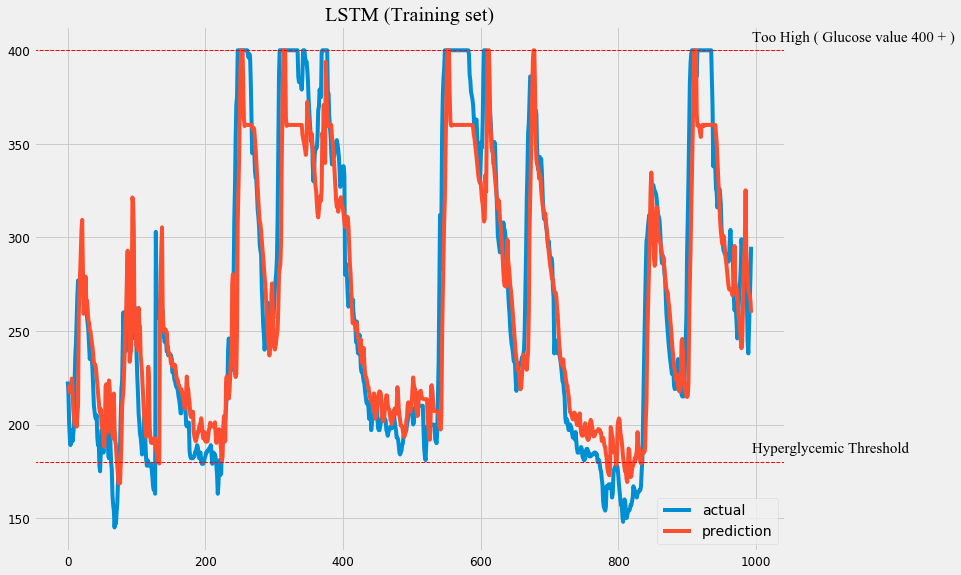

In [343]:
# 트레이닝셋
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
#plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Training set)',family='Times New Roman')
plt.legend()
plt.show()

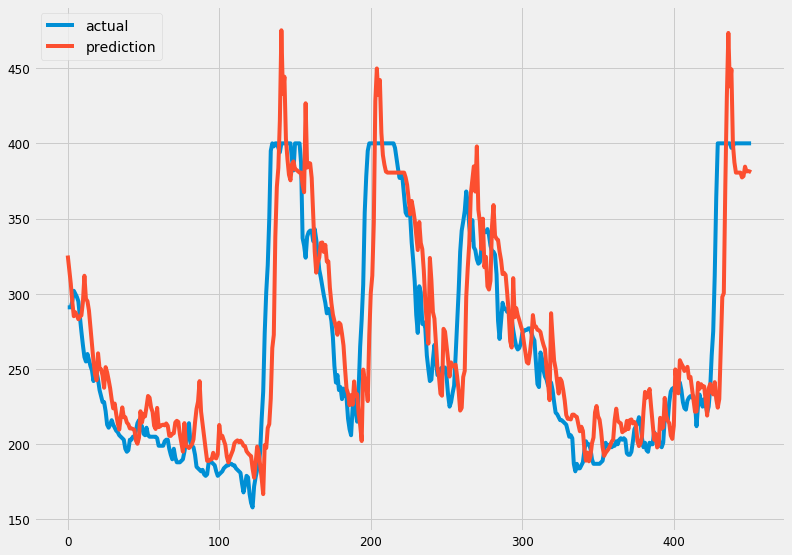

In [72]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.legend()
plt.show()

In [73]:
predict_result = model.predict(x_train_uni,verbose=0)

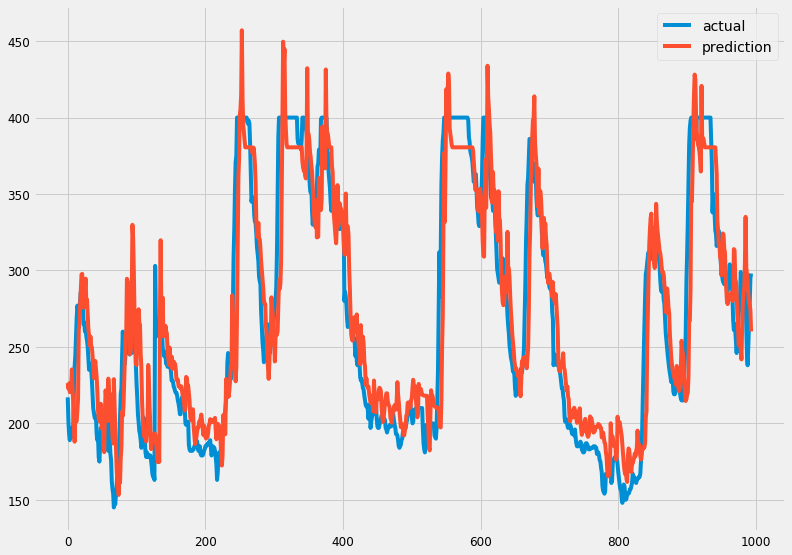

In [74]:
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.legend()
plt.show()

## Stacked LSTM

In [439]:
model = Sequential()
model.add(LSTM(50,activation='relu',return_sequences=True,input_shape=(n_steps,n_features)))
model.add(LSTM(50,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [440]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [441]:
predict_result = model.predict(x_val_uni,verbose=0)


In [442]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [443]:
print(' Stacked LSTM - RMSE(15min) : ',RMSE(y_val_uni,predict_result))

 Stacked LSTM - RMSE(15min) :  47.34159678347732


In [444]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / STACKED LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))

 Training set / STACKED LSTM - RMSE (60min) Training set :  42.17171906285269


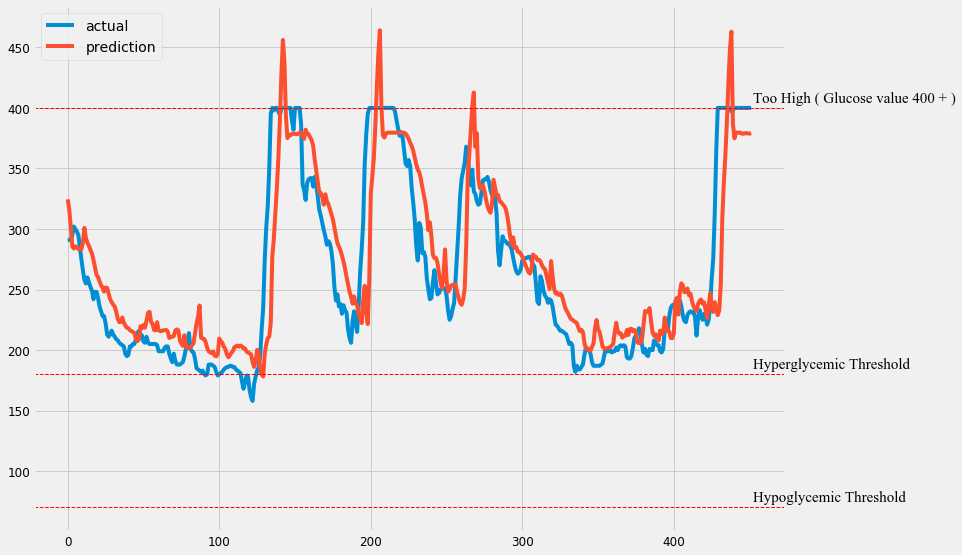

In [83]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.legend()
plt.show()

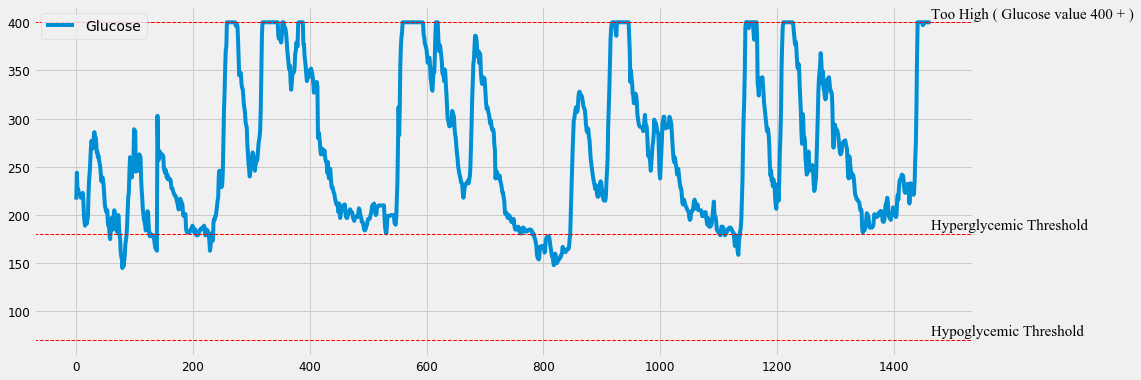

In [80]:
df.plot(figsize=(15,6))
plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
#plt.annotate(df['Timestamp'][13],xy=(-50,40),xytext=(-50,0),fontsize=20,bbox=dict(boxstyle='square',
#                                                               color='white'),arrowprops=dict(facecolor='black'))
#plt.annotate(df['Timestamp'][len(df['Timestamp'])],xytext=(-,0),fontsize=20,bbox=dict(boxstyle='square',
 #                                                              color='white'))
plt.text(len(df['Timestamp']),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(df['Timestamp']),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

#y=70
#plt.plot(y,'b--',linestyles='--'),
#plt.hlines(70,linestyles='--')
plt.show()

In [208]:
predict_result = model.predict(x_train_uni,verbose=0)

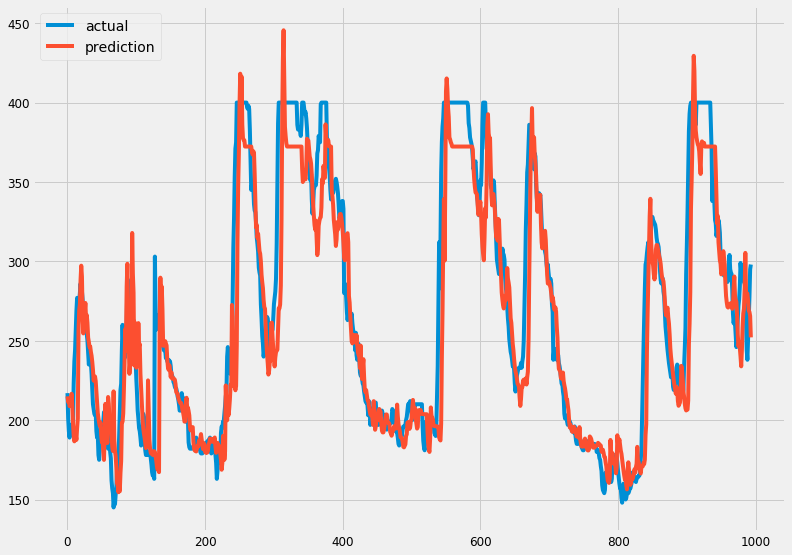

In [209]:
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.legend()
plt.show()

## Bidirectional LSTM

In [445]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [446]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

Bidirectional LSTM - RMSE :  37.68991042653597


In [447]:
predict_result = model.predict(x_val_uni,verbose=0)

In [448]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [449]:
print('Bidirectional LSTM - RMSE : ',RMSE(y_val_uni,predict_result))
#상한선 400 아닐 때 rmse - 37.68
#상한선 400일 때 RMSE - 36.46

Bidirectional LSTM - RMSE :  50.13111268248649


In [450]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / Bidirectional LSTM - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))

 Training set / Bidirectional LSTM - RMSE (60min) Training set :  43.92914313769454


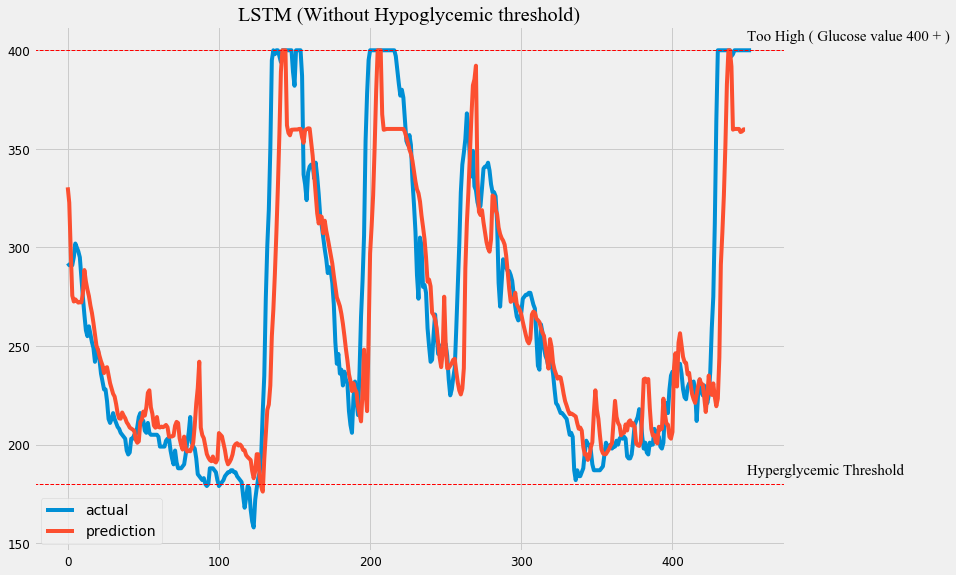

In [333]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
#plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)
plt.title('LSTM (Without Hypoglycemic threshold)',family='Times New Roman')
plt.legend()
plt.show()

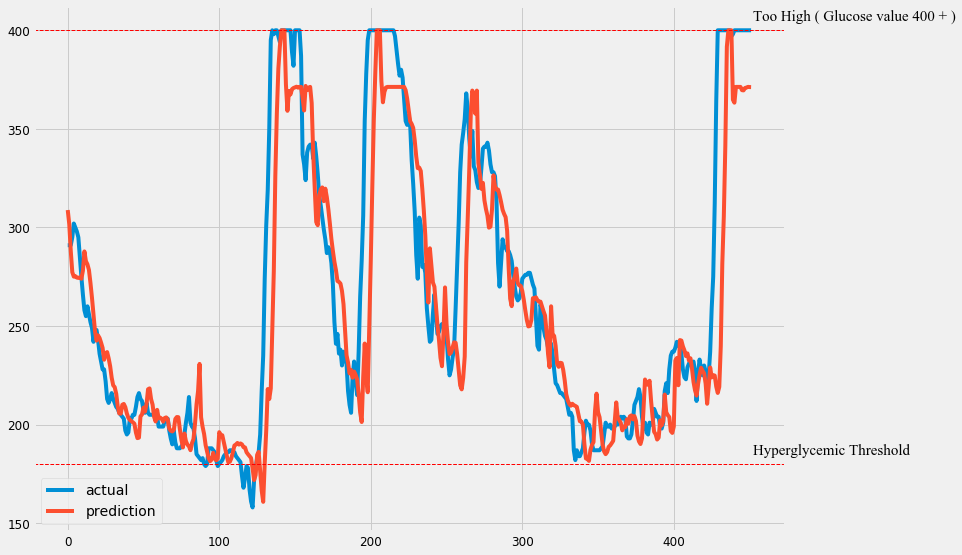

In [91]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
#plt.axhline(y=70,c='r',linestyle='--',linewidth=1)
plt.axhline(y=180,c='r',linestyle='--',linewidth=1)
plt.axhline(y=400,c='r',linestyle='--',linewidth=1)
plt.text(len(predict_result),185,'Hyperglycemic Threshold',family='Times New Roman',size=15)
#plt.text(len(predict_result),75,'Hypoglycemic Threshold',family='Times New Roman',size=15)
plt.text(len(predict_result),405,'Too High ( Glucose value 400 + )',family='Times New Roman',size=15)

plt.legend()
plt.show()

In [225]:
predict_result = model.predict(x_train_uni,verbose=0)

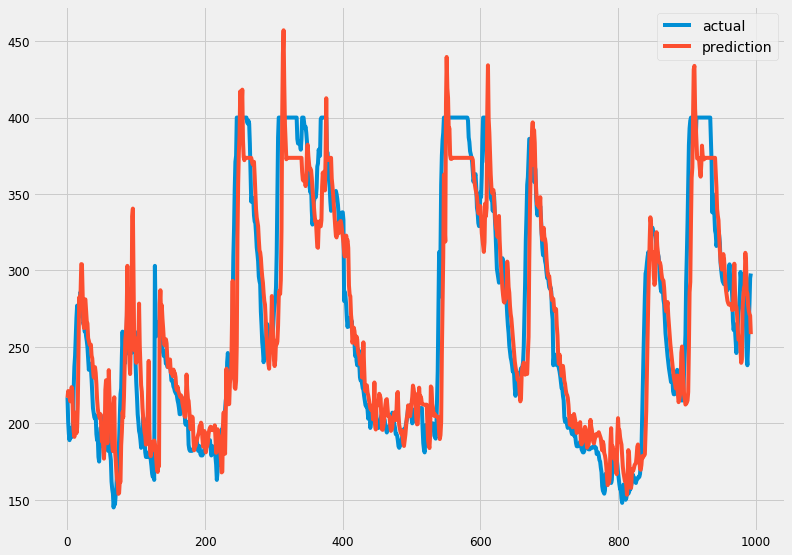

In [226]:
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.legend()
plt.show()

## GRU

In [451]:
from keras.layers import GRU
model = Sequential()
model.add(GRU(50,activation='relu',input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [452]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 50)                7950      
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [453]:
model.fit(x_train_uni,y_train_uni,epochs=200,verbose=0)

In [454]:
predict_result = model.predict(x_val_uni,verbose=0)

In [455]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

In [431]:
predict_result

array([[298.3645 ],
       [320.69406],
       [302.75638],
       [283.2887 ],
       [278.28244],
       [294.3018 ],
       [291.06616],
       [289.7833 ],
       [292.8396 ],
       [294.15076],
       [303.31808],
       [313.98837],
       [303.93472],
       [287.05484],
       [290.10065],
       [270.02744],
       [257.84152],
       [249.07883],
       [241.98642],
       [244.40161],
       [260.52524],
       [255.03923],
       [244.84781],
       [246.33003],
       [234.71175],
       [253.04684],
       [255.25732],
       [236.43867],
       [228.19597],
       [228.40077],
       [224.68169],
       [230.12956],
       [219.36163],
       [206.15881],
       [211.07281],
       [219.41061],
       [226.87442],
       [212.93518],
       [217.1073 ],
       [211.15005],
       [211.49152],
       [208.65982],
       [208.64313],
       [207.94827],
       [206.93048],
       [196.21411],
       [200.07242],
       [205.62567],
       [220.76941],
       [208.53883],


In [322]:
predict_result

array([[318.28967],
       [315.23886],
       [309.97415],
       [295.74118],
       [282.5794 ],
       [285.88812],
       [285.46423],
       [283.70758],
       [285.561  ],
       [287.39352],
       [291.5956 ],
       [301.52515],
       [299.8835 ],
       [295.32898],
       [291.06738],
       [277.1996 ],
       [261.1998 ],
       [250.60013],
       [241.95338],
       [239.86174],
       [250.77852],
       [250.91777],
       [247.17726],
       [245.65424],
       [238.33018],
       [243.71214],
       [247.74522],
       [242.0965 ],
       [232.79521],
       [229.83594],
       [223.6252 ],
       [224.07077],
       [219.20958],
       [209.39503],
       [207.6791 ],
       [213.44185],
       [218.59773],
       [217.27695],
       [216.83397],
       [215.05827],
       [213.2655 ],
       [209.90703],
       [209.71469],
       [209.46109],
       [209.09981],
       [201.95003],
       [199.28737],
       [201.76915],
       [212.00563],
       [213.66495],


In [456]:

print('GRU - RMSE : ',RMSE(y_val_uni,predict_result))
# 상한선 400일 때 RMSE - 38.30 
# 상한선 400 X - 38.63

GRU - RMSE :  48.50790372510491


In [457]:
# 트레이닝셋 RMSE 계산 
predict_result = model.predict(x_train_uni,verbose=0)
# 예측값 상한선 = 400 
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400
print(' Training set / GRU - RMSE (60min) Training set : ',RMSE(y_train_uni,predict_result))

 Training set / GRU - RMSE (60min) Training set :  41.996591876941295


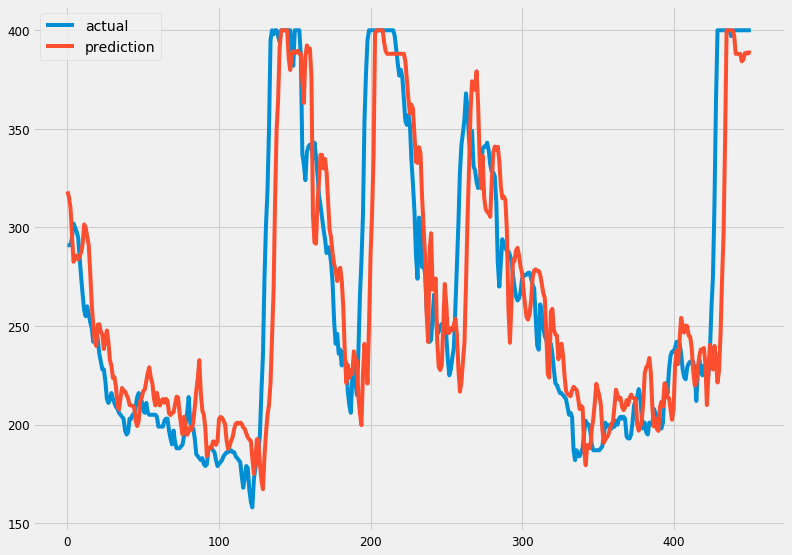

In [315]:
plt.figure(figsize=(12,9))
plt.plot(y_val_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.legend()
plt.show()

In [316]:
predict_result = model.predict(x_train_uni,verbose=0)

In [317]:
for i in range(len(predict_result)):
    if predict_result[i] >= 400: 
        predict_result[i]=400

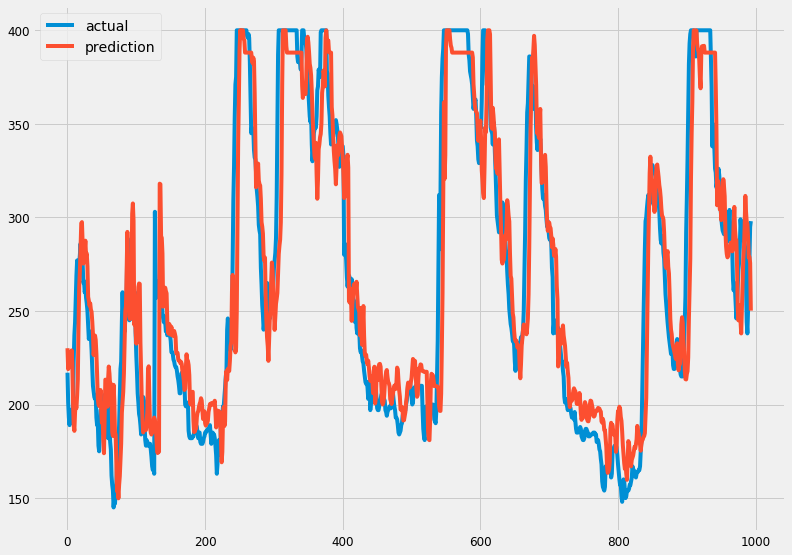

In [318]:
plt.figure(figsize=(12,9))
plt.plot(y_train_uni,label='actual')
plt.plot(predict_result,label='prediction')
plt.legend()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002215CBBC0A0>]],
      dtype=object)

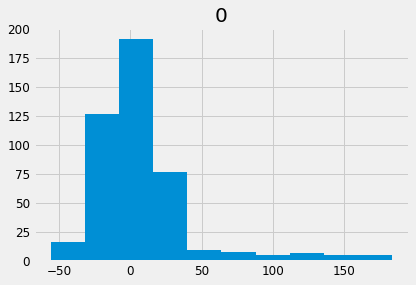

In [98]:
from pandas import DataFrame
residuals = [y_val_uni[i]-predict_result[i] for i in range(len(predict_result))]
residuals=DataFrame(residuals)
residuals.hist()

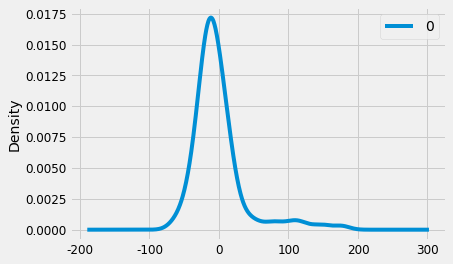

In [290]:
residuals.plot(kind='kde')

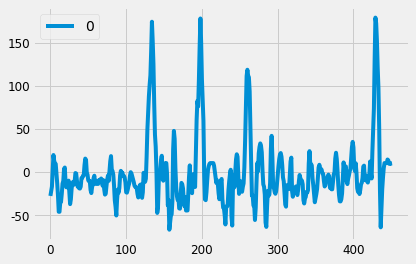

In [295]:
residuals.plot()

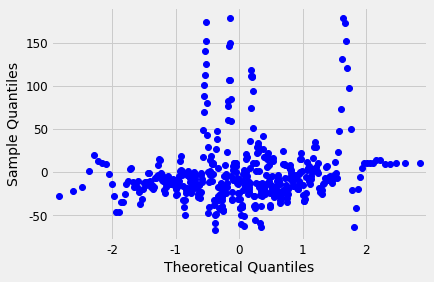

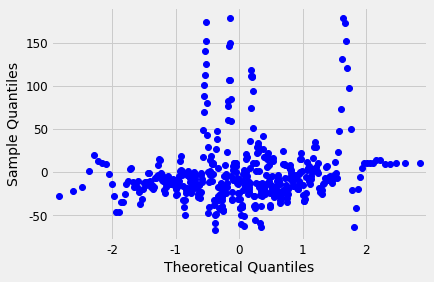

In [293]:
from statsmodels.graphics.gofplots import qqplot
residuals=np.array(residuals)
qqplot(residuals)

## CNN LSTM

In [138]:
n_seq = 3 
n_steps = 3 
x_train_uni = x_train_uni.reshape((x_train_uni.shape[0],2,2,1))


ValueError: cannot reshape array of size 5964 into shape (994,2,2,1)

In [139]:
x_train_uni.shape

(994, 6, 1)

In [126]:
X

1461

In [129]:
#x_test = [10,20,30,40,50,60,70,80,90]
#n_steps_test = 4 
#x_test,y_test = split_sequence(x_test,n_steps_test)

In [130]:
#x_test=x_test.reshape((x_test.shape[0],2,2,1))

In [132]:
#x_test.shape

(5, 2, 2, 1)

In [ ]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50,activation='relu'),input_shape=(n_steps,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [56]:
split_sequence(raw_seq,n_steps)

NameError: name 'raw_seq' is not defined

In [158]:
X.shape

(1458, 6)

In [132]:
raw_seq

array([216, 244, 227, ..., 400, 400, 400], dtype=int64)

In [133]:
X,y = split_sequence(raw_seq,n_steps,delay)

In [153]:
for i in range(len(X)):
    print(X[i],y[i])

[216 244 227 227 224 223] 222
[244 227 227 224 223 222] 222
[227 227 224 223 222 222] 218
[227 224 223 222 222 218] 218
[224 223 222 222 218 218] 218
[223 222 222 218 218 218] 223
[222 222 218 218 218 223] 217
[222 218 218 218 223 217] 201
[218 218 218 223 217 201] 193
[218 218 223 217 201 193] 189
[218 223 217 201 193 189] 197
[223 217 201 193 189 197] 196
[217 201 193 189 197 196] 191
[201 193 189 197 196 191] 195
[193 189 197 196 191 195] 199
[189 197 196 191 195 199] 223
[197 196 191 195 199 223] 237
[196 191 195 199 223 237] 244
[191 195 199 223 237 244] 257
[195 199 223 237 244 257] 269
[199 223 237 244 257 269] 277
[223 237 244 257 269 277] 274
[237 244 257 269 277 274] 269
[244 257 269 277 274 269] 275
[257 269 277 274 269 275] 280
[269 277 274 269 275 280] 286
[277 274 269 275 280 286] 279
[274 269 275 280 286 279] 281
[269 275 280 286 279 281] 276
[275 280 286 279 281 276] 265
[280 286 279 281 276 265] 266
[286 279 281 276 265 266] 260
[279 281 276 265 266 260] 262
[281 276 2

[291 291 290 287 289 298] 304
[291 290 287 289 298 304] 295
[290 287 289 298 304 295] 293
[287 289 298 304 295 293] 292
[289 298 304 295 293 292] 282
[298 304 295 293 292 282] 267
[304 295 293 292 282 267] 261
[295 293 292 282 267 261] 265
[293 292 282 267 261 265] 261
[292 282 267 261 265 261] 254
[282 267 261 265 261 254] 246
[267 261 265 261 254 246] 255
[261 265 261 254 246 255] 265
[265 261 254 246 255 265] 272
[261 254 246 255 265 272] 276
[254 246 255 265 272 276] 284
[246 255 265 272 276 284] 299
[255 265 272 276 284 299] 294
[265 272 276 284 299 294] 295
[272 276 284 299 294 295] 295
[276 284 299 294 295 295] 291
[284 299 294 295 295 291] 287
[299 294 295 295 291 287] 286
[294 295 295 291 287 286] 283
[295 295 291 287 286 283] 263
[295 291 287 286 283 263] 244
[291 287 286 283 263 244] 238
[287 286 283 263 244 238] 251
[286 283 263 244 238 251] 264
[283 263 244 238 251 264] 278
[263 244 238 251 264 278] 295
[244 238 251 264 278 295] 298
[238 251 264 278 295 298] 302
[251 264 2

In [111]:
df['Glucose'].head(20)

0     216
1     244
2     227
3     227
4     224
5     223
6     222
7     222
8     218
9     218
10    218
11    223
12    217
13    201
14    193
15    189
16    197
17    196
18    191
19    195
Name: Glucose, dtype: object

In [50]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['Glucose']])
df_scaled = pd.DataFrame(df_scaled)
print(df_scaled)
#df_scaled = pd.DataFrame(df_scaled)

             0
0     0.278431
1     0.388235
2     0.321569
3     0.321569
4     0.309804
...        ...
1459  1.000000
1460  1.000000
1461  1.000000
1462  1.000000
1463  1.000000

[1464 rows x 1 columns]


,0
0,0.278431
1,0.388235
2,0.321569
3,0.321569
4,0.309804
...,...
1059,0.278431
1060,0.266667
1061,0.262745
1062,0.243137


In [57]:
def make_dataset(data,label, window_size = 6):
    feature_list =[]
    label_list = []
    for i in range(len(data)-window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list),np.array(label_list)

In [61]:
def create_dataset(dataset,look_back=6):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        a= dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX),np.array(dataY)

In [62]:
look_back=6
trainX,trainY=create_dataset(train,look_back)
testX,testY=create_dataset(test,look_back)

KeyError: 6

In [132]:
# Tensorflow v2 때부터 Session, Placeholder 없어짐 
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 
from __future__ import absolute_import,division,print_function,unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

In [100]:
tf.reset_default_graph()

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [101]:
# 데이터프레임을 numpy 배열 형태로 변환 
numpy_glucose = df['Glucose'].to_numpy()
numpy_glucose.astype('float32')

array([216., 244., 227., ..., 400., 400., 400.], dtype=float32)

In [102]:
numpy_glucose

array([216, 244, 227, ..., 400, 400, 400], dtype=object)

In [103]:
from sklearn.model_selection import train_test_split
X_train,Y_train=train_test_split(numpy_glucose,test_size=0.3,shuffle=False)

In [84]:
X_train.shape

(1024,)

In [85]:
Y_train.shape

(440,)

In [86]:
n_steps=20
n_neurons=100
n_inputs=1
n_outputs=1

In [87]:
X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32, [None,n_steps, n_outputs])

In [88]:
cell = tf.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [89]:
stacked_rnn_outputs = tf.reshape(tensor=rnn_outputs, shape=[-1,n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs,n_outputs)
predictions = tf.reshape(stacked_outputs,[-1,n_steps,n_outputs])

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [90]:
learning_rate = 0.0001
n_iterations = 600
batch_size = 50

In [91]:
mse = tf.losses.mean_squared_error(labels=y,predictions=predictions)

In [92]:
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(mse)

In [ ]:
def time_se

In [95]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for iteration in range(n_iterations):
        batch_x,batch_y = next_batch(batch_size,n_steps)
        sess.run(train_op,feed_dict = {X:batch_x,y:batch_y})
        if iteration %100 == 0 :
            loss=mse.eval(feed_dict={X:batch_x,y:batch_y})
            print('step:{:03d},MSE:{:.4f}'.format(iteration,loss))
        
    X_new = time_series(np.array(t_instance[:-1].reshape(-1,n_steps,n_inputs)))
    y_pred = sess.run(predictions,feed_dict = {X:X_new})
    
print('y_pred:{}\n{}'.format(y_pred.shape,y_pred))

plt.title("Testing the Model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")
plt.show()

NameError: name 'next_batch' is not defined

In [115]:
def uni_data(dataset,start_index, end_index, history_size, target_size):
    data=[]
    labels=[]
    
    start_index= start_index+history_size
    if end_index is None:
        end_index = len(dataset)-target_size
        
    for i in range(start_index,end_index):
        indices = range(i-history_size,i)
        
        data.append(np.reshape(dataset[indices],(history_size,1)))
        labels.append(dataset[i+target_size])
    return np.array(data),np.array(labels)

In [107]:
TRAIN_SPLIT=1000
uni_train_mean=numpy_glucose[:TRAIN_SPLIT].mean()
uni_train_std = numpy_glucose[:TRAIN_SPLIT].std()
numpy_glucose =(numpy_glucose-uni_train_mean)/uni_train_std

In [145]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [165]:
def create_dataset(dataset,look_back=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-look_back-1):
        a= dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX),np.array(dataY)

In [166]:
look_back=1
trainX,trainY=create_dataset(X_train,look_back)
testX,testY=create_dataset(Y_train,look_back)

In [167]:
trainX.shape

(1022, 1)

In [168]:
trainX=np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX=np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

In [169]:
trainX.shape

(1022, 1, 1)

In [170]:
model = Sequential()
model.add(LSTM(4,input_shape=(1,look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(trainX,trainY,epochs=100,batch_size=1,verbose=2)


Train on 1022 samples
Epoch 1/100
1022/1022 - 1s - loss: 76919.1796
Epoch 2/100
1022/1022 - 1s - loss: 76005.8920
Epoch 3/100
1022/1022 - 1s - loss: 75100.8620
Epoch 4/100
1022/1022 - 1s - loss: 74199.6769
Epoch 5/100
1022/1022 - 1s - loss: 73309.2370
Epoch 6/100
1022/1022 - 1s - loss: 72424.9555
Epoch 7/100
1022/1022 - 1s - loss: 71545.1492
Epoch 8/100
1022/1022 - 1s - loss: 70670.5888
Epoch 9/100
1022/1022 - 1s - loss: 69806.3066
Epoch 10/100
1022/1022 - 1s - loss: 68948.1319
Epoch 11/100
1022/1022 - 1s - loss: 68097.2235
Epoch 12/100
1022/1022 - 1s - loss: 67248.5138
Epoch 13/100
1022/1022 - 1s - loss: 66407.3108
Epoch 14/100
1022/1022 - 1s - loss: 65572.8430
Epoch 15/100
1022/1022 - 1s - loss: 64745.1532
Epoch 16/100
1022/1022 - 1s - loss: 63925.1846
Epoch 17/100
1022/1022 - 1s - loss: 63109.8981
Epoch 18/100
1022/1022 - 1s - loss: 62301.7954
Epoch 19/100
1022/1022 - 1s - loss: 61500.5517
Epoch 20/100
1022/1022 - 1s - loss: 60705.2246
Epoch 21/100
1022/1022 - 1s - loss: 59915.6357


In [171]:
testPredict=model.predict(testX)
#testPredict=scaler.inverse_transform(testPredict)
testScore=math.sqrt(mean_squared_error(testY,testPredict))
print('Train Score : %.2f RMSE' % testScore)

Train Score : 124.63 RMSE


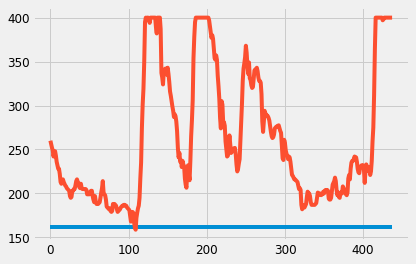

In [172]:
plt.plot(testPredict)
plt.plot(testY)
plt.show()

In [144]:
model=tf.keras.Sequential([tf.keras.layers.SimpleRNN(units=1,
                                                    activation='tanh',
                                                    return_sequences=True,
                                                    return_state=True)])

In [ ]:
for i in range(len(numpy_))

In [118]:
uni_past_history = 6
uni_future_target = 6


In [119]:
x_train_uni,y_train_uni = uni_data(numpy_glucose,0,TRAIN_SPLIT,
                                  uni_past_history,
                                  uni_future_target)
x_val_uni,y_val_uni=uni_data(numpy_glucose,TRAIN_SPLIT,None,
                            uni_past_history,
                            uni_future_target)

In [120]:
print ('하나의 Window에서 과거 기록 ( 30분 전까지 혈당값으로 미래 혈당값 예측)')
print(x_train_uni[0])
print('\n 30분 뒤의 혈당')
print(y_train_uni[0])

하나의 Window에서 과거 기록 ( 30분 전까지 혈당값으로 미래 혈당값 예측)
[[-0.6402768082755709]
 [-0.2860395055646688]
 [-0.5011121536391451]
 [-0.5011121536391451]
 [-0.5390661503581703]
 [-0.5517174825978454]]

 30분 뒤의 혈당
-0.6276254760358958


In [121]:
def create_time_steps(length):
    return list(range(-length,0))

In [124]:
def show_plot(plot_data,delta,title):
    labels=['History','True Future','Model Prediction']
    marker=['.-','rx','go']
    time_steps=create_time_steps(plot_data[0].shape[0])
    if delta:
        future=delta
    else:
        future=0
    
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future,plot_data[i],marker[i],markersize=10,
                    label=labels[i])
        else:
            plt.plot(time_steps,plot_data[i].flatten(),marker[i],label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0],(future+5)*2])
        plt.xlabel('Time-Step')
        return plt
    

<module 'matplotlib.pyplot' from 'C:\\Users\\user\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

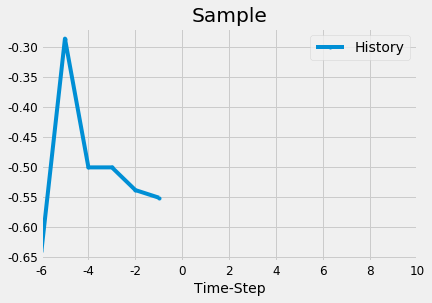

In [125]:
show_plot([x_train_uni[0],y_train_uni[0]],0,'Sample')

In [126]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\user\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

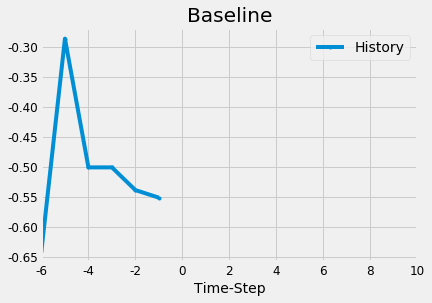

In [127]:
show_plot([x_train_uni[0],y_train_uni[0],baseline(x_train_uni[0])],0,'Baseline')

d

In [173]:
model=Sequential()
model.add(Dense(30,input_dim=1,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [174]:
model.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])
model.fit(X_train,Y_train,epochs=30,batch_size=10)

ValueError: Input arrays should have the same number of samples as target arrays. Found 1024 input samples and 440 target samples.

In [139]:
BATCH_SIZE=256
BUFFER_SIZE=10000

#train_univariate=tf.data.Dataset.from_tensor_slices((x_train_uni,y_train_uni))
#train_univariate=train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate=tf.data.Dataset.from_tensor_slices((x_val_uni,y_val_uni))

TypeError: Expected binary or unicode string, got -0.3619474990027192

In [130]:
x_train_uni

array([[[-0.6402768082755709],
        [-0.2860395055646688],
        [-0.5011121536391451],
        [-0.5011121536391451],
        [-0.5390661503581703],
        [-0.5517174825978454]],

       [[-0.2860395055646688],
        [-0.5011121536391451],
        [-0.5011121536391451],
        [-0.5390661503581703],
        [-0.5517174825978454],
        [-0.5643688148375204]],

       [[-0.5011121536391451],
        [-0.5011121536391451],
        [-0.5390661503581703],
        [-0.5517174825978454],
        [-0.5643688148375204],
        [-0.5643688148375204]],

       ...,

       [[0.34652710641908496],
        [0.35917843865876004],
        [0.35917843865876004],
        [0.30857310970005974],
        [0.25796778074135945],
        [0.24531644850168435]],

       [[0.35917843865876004],
        [0.35917843865876004],
        [0.30857310970005974],
        [0.25796778074135945],
        [0.24531644850168435],
        [0.20736245178265914]],

       [[0.35917843865876004],
        [0.30857

Timestamp    0
Event        0
Glucose      0
dtype: int64